In [1]:
%matplotlib inline

# 1. Load dependencies 

In [2]:
import model
import v1.func as func
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.optim as optim
import torch.nn.functional as F

# 2. Defining the dataset

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

<br>
Define the batch size :
<br><br>

In [4]:
batch_size = 4

<br>Load data from CIFAR-10:<br><br>

In [5]:
trainloader, testloader, classes = func.getData(batch_size, transform)

Files already downloaded and verified
Files already downloaded and verified


<br>Here is an idea of the CIFAR-10 dataset : <br><br>

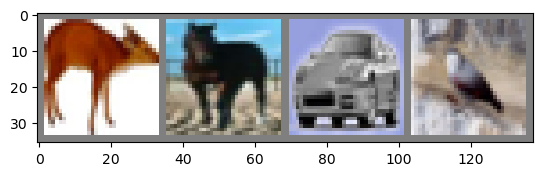

deer  horse car   bird 


In [6]:
    def imshow(img):
        img = img / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 3. Defining the model

Defining the network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<br>Defining the loss function and optimizer<br>

In [8]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Defining the number of epochs: 

In [9]:
epochs = 2

# 4. Train the model

Defining the train function for our model : 

In [10]:
def train(model, trainloader, testloader, criterion, optimizer, device, epochs):
    model.to(device)
    start_time = time.time()
    
    losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_samples += len(labels)

        loss_percentage = (running_loss / total_samples) * 100

        
        train_acc = func.evaluate(model, trainloader, device)
        test_acc = func.evaluate(model, testloader, device)

        losses.append(loss_percentage)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print('Epoch [%d/%d]\nLoss: %.4f' % (epoch+1, epochs, running_loss))
        print('Training Accuracy: %.2f %%' % (train_acc))
        print('Test Accuracy: %.2f %%' % (test_acc))
        print('\n')

    end_time = time.time()
    total_time = end_time - start_time
    total_flops = (2 * 3 * 5 * 5 * 6 * 14 * 14 + 6 * 5 * 5 * 16 * 5 * 5 + 16 * 5 * 5 * 120 + 120 * 84 + 84 * 10) * len(trainloader.dataset)
    total_adds = total_flops // 2
    total_muls = total_flops // 2
    total_maxs = (2 * 5 * 5 * 6 * 14 * 14 + 2 * 5 * 5 * 16 * 5 * 5) * len(trainloader.dataset)
    total_ops = total_adds + total_muls + total_maxs
    ops_per_second = total_ops / total_time

    print('Total FLOPs: %.2f' % (total_flops))
    print('Total Additions: %.2f' % (total_adds/1000000000))
    print('Total Multiplications (in billion) : %.2f' % (total_muls/1000000000))
    print('Total Maximums(in billion): %.2f' % (total_maxs/1000000000))
    print('Total Operations(in billion): %.2f' % (total_ops/1000000000))
    print('Total Time: %.2f seconds' % (total_time))
    print('Operations Per Second (in million) : %.2f' % (ops_per_second/1000000))
    print('\nFinished Training')
    
    return losses, train_accuracies, test_accuracies

<br> Execute the training : <br> <br>

In [11]:
losses, train_accuracies, test_accuracies = train(net, trainloader, testloader, criterion, optimizer, device, epochs)

Epoch [1/2]
Loss: 21866.3212
Training Accuracy: 48.17 %
Test Accuracy: 48.08 %


Epoch [2/2]
Loss: 16708.0296
Training Accuracy: 55.16 %
Test Accuracy: 52.80 %


Total FLOPs: 14766000000.00
Total Additions: 7.38
Total Multiplications (in billion) : 7.38
Total Maximums(in billion): 3.94
Total Operations(in billion): 18.71
Total Time: 124.15 seconds
Operations Per Second (in million) : 150.68

Finished Training


# 5. General performance

Plot general performance of training : 

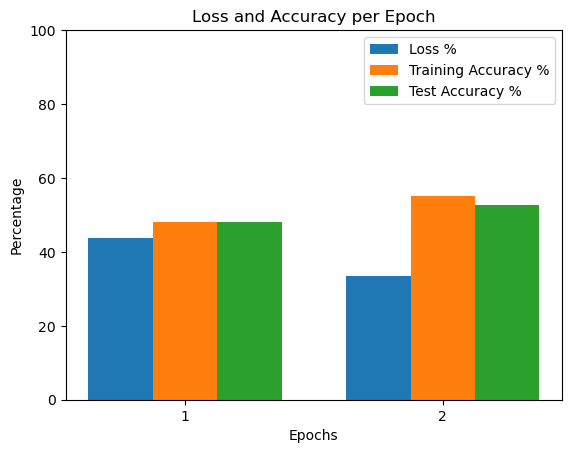

In [12]:
func.plot_training_stats(losses, train_accuracies, test_accuracies, epochs)

# 6. Performance by classes : 

In [13]:
class_accuracy = func.class_performance(net, testloader, device, classes)

<br> Plot perf by classes for the current training<br>

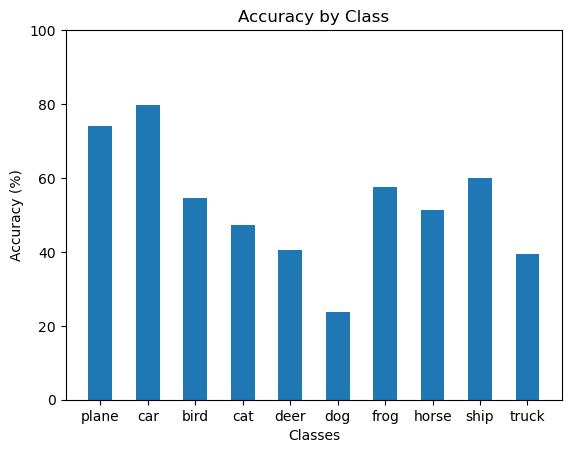

In [14]:
func.plot_class_performance(class_accuracy, classes)